In [1]:
%matplotlib inline

In [2]:
from pylab import *
import pylab
import matplotlib as mpl
import numpy
import lnm
from graph import Graph
mpl.rcParams['savefig.dpi'] = 180
OPTIONS = {'FSM': 'results_fsm.txt',
           'Snake': 'results_snake.txt',
           'Tetris': 'results_tetris.txt',
           'Suffix Tree': 'results_suffixtree.txt',
           'Synth':'results_synth.txt'}
import ipywidgets as widgets
from IPython.display import display
s = widgets.Dropdown(options=OPTIONS)

In [16]:
display(s)

In [17]:
s.value

'results_synth.txt'

# Select Benchmark:

In [18]:
graph = lnm.read_data(s.value)
variations, data = graph.ungraph()
hidden_untyped = data[0,2]
pycket_untyped = data[0,1]
racket_untyped = data[0,0]
hidden = data[:,2]
pycket = data[:,1]
racket = data[:,0]

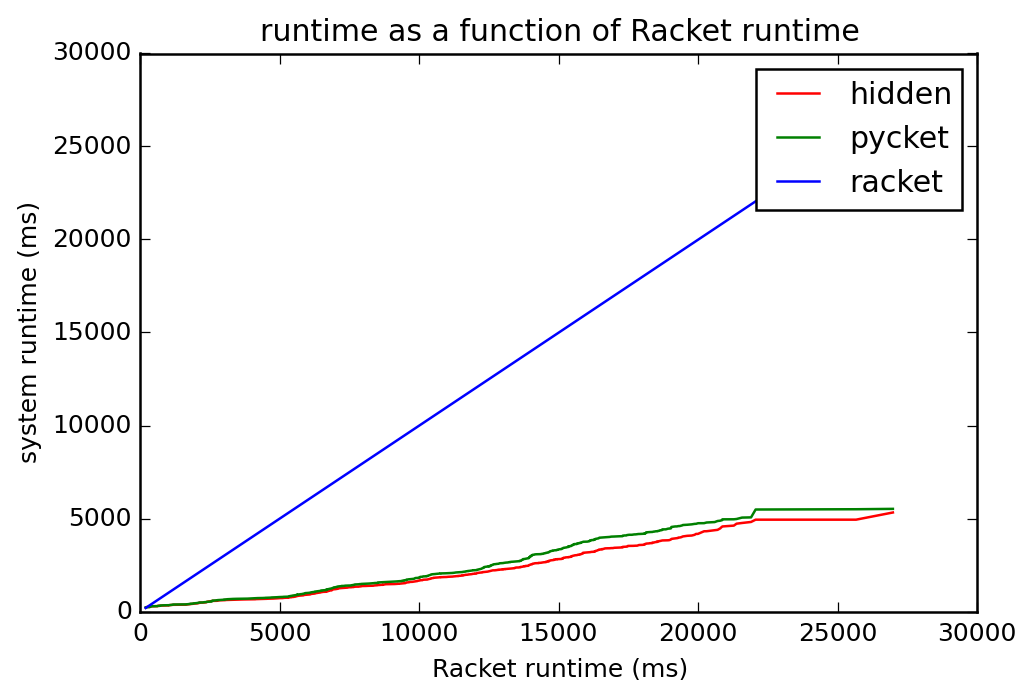

In [19]:
# Runtime of Pycket as a function of Racket
ordered_data = np.copy(data)
ordered_data.sort(axis=0)
ohidden = ordered_data[:,2]
opycket = ordered_data[:,1]
oracket = ordered_data[:,0]
pylab.plot(oracket, ohidden, 'r', label='hidden')
pylab.plot(oracket, opycket, 'g', label='pycket')
pylab.plot(oracket, oracket, 'b', label='racket')
pylab.title('runtime as a function of Racket runtime')
pylab.xlabel('Racket runtime (ms)')
pylab.ylabel('system runtime (ms)')
pylab.legend()

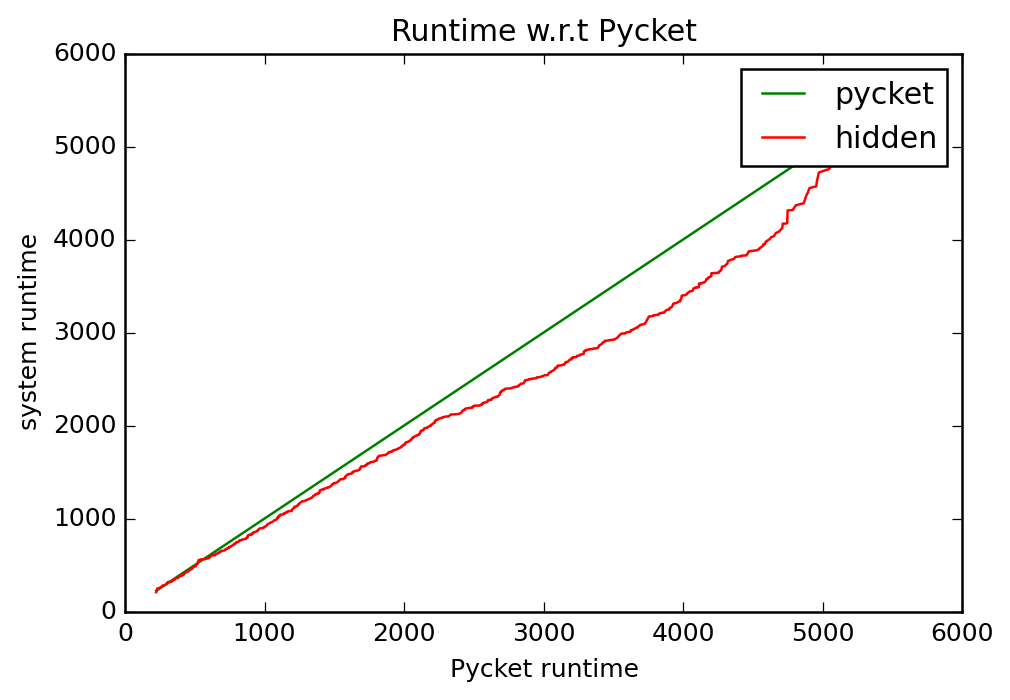

In [20]:
pylab.plot(opycket, opycket, 'g', label='pycket')
pylab.plot(opycket, ohidden, 'r', label='hidden')
pylab.title('Runtime w.r.t Pycket')
pylab.xlabel('Pycket runtime')
pylab.ylabel('system runtime')
pylab.legend()

In [21]:
from scipy.stats import cumfreq
from pandas      import DataFrame
from ipy_table   import *

hidden_slowdown = hidden / float(hidden_untyped)
pycket_slowdown = pycket / float(pycket_untyped)
racket_slowdown = racket / float(racket_untyped)

def compute_deliverable(data):
    th = sum(data < 3)
    oh = sum(numpy.logical_and(data >= 3, data < 10))
    return [max(data), numpy.mean(data), np.median(data), "%d (%0.2f%%)" % (th, th / float(len(data)) * 100), "%d (%0.2f%%)" % (oh, oh / float(len(data)) * 100)]

def make_deliverable_table(**kwargs):
    lst = [["", "Max overhead", "Mean overhead", "Median overhead", "300-deliverable", "300/1000-usable"]]
    for name, data in kwargs.iteritems():
        lst.append([name] + compute_deliverable(data))
    tbl = make_table(map(list, zip(*lst)))
    apply_theme('basic_both')
    return tbl

def slowdown_cdf(*args):
    for data, color, label in args:
        counts, bin_edges = numpy.histogram(data, bins=len(data))
        cdf = numpy.cumsum(counts)
        pylab.plot(bin_edges[:-1], cdf, color=color, label=label)
    pylab.axvline(3, color='y')
    pylab.axvline(10, color='k')
    pylab.axhline(len(data) * 0.6, color='c', ls='--')
    pylab.xlabel('slowdown factor')
    pylab.xlim((1,20))
    pylab.ylim((0,len(racket)))
    pylab.ylabel('number below')
    pylab.legend()

# Slowdown Summary Stats

In [22]:
DataFrame({'racket':racket_slowdown, 'pycket':pycket_slowdown, 'hidden':hidden_slowdown}).describe()

,hidden,pycket,racket
count,1024.000000,1024.000000,1024.000000
mean,7.297794,9.105063,53.393127
std,4.030616,5.261675,26.227077
min,0.818898,0.965368,1.000000
25%,3.768701,4.519481,32.192708
50%,7.202756,8.790043,55.541667
75%,9.952756,12.950216,72.932292
max,20.956693,23.887446,140.479167


# Deliverability Stats

## L = 0

In [23]:
make_deliverable_table(racket=racket_slowdown,pycket=pycket_slowdown,hidden=hidden_slowdown)

,racket,hidden,pycket
Max overhead,140.4792,20.9567,23.8874
Mean overhead,53.3931,7.2978,9.1051
Median overhead,55.5417,7.2028,8.7900
300-deliverable,9 (0.88%),190 (18.55%),127 (12.40%)
300/1000-usable,43 (4.20%),582 (56.84%),499 (48.73%)


## L = 1

In [24]:
slowdown_graph = Graph.fromkeyvals(variations, np.array(zip(racket_slowdown, pycket_slowdown, hidden_slowdown)))
graph1 = lnm.compute_lnm_times(slowdown_graph, L=1)
_, data1 = graph1.ungraph()
racket_slowdown1 = data1[:,0]
pycket_slowdown1 = data1[:,1]
hidden_slowdown1 = data1[:,2]
make_deliverable_table(racket=racket_slowdown1,pycket=pycket_slowdown1,hidden=hidden_slowdown1)

,racket,hidden,pycket
Max overhead,65.3333,10.2874,12.7662
Mean overhead,26.3914,3.2928,3.9330
Median overhead,27.8750,2.7323,3.2706
300-deliverable,47 (4.59%),591 (57.71%),439 (42.87%)
300/1000-usable,150 (14.65%),432 (42.19%),532 (51.95%)


## L = 2

In [25]:
graph2 = lnm.compute_lnm_times(slowdown_graph, L=2)
_, data2 = graph2.ungraph()
racket_slowdown2 = data2[:,0]
pycket_slowdown2 = data2[:,1]
hidden_slowdown2 = data2[:,2]
make_deliverable_table(racket=racket_slowdown2,pycket=pycket_slowdown2,hidden=hidden_slowdown2)

,racket,hidden,pycket
Max overhead,36.1458,4.8819,5.3506
Mean overhead,13.1042,1.8112,2.0742
Median overhead,10.5625,1.5197,1.7576
300-deliverable,173 (16.89%),950 (92.77%),819 (79.98%)
300/1000-usable,323 (31.54%),74 (7.23%),205 (20.02%)


# Slowdown distribution

## L = 0

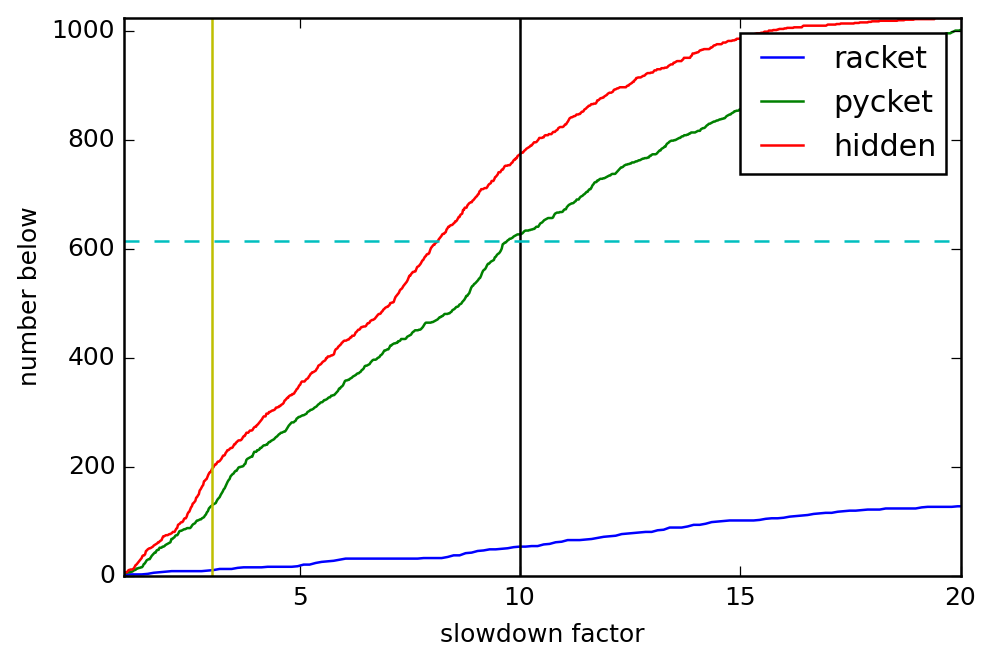

In [26]:
slowdown_cdf((racket_slowdown, 'b', 'racket'),
             (pycket_slowdown, 'g', 'pycket'),
             (hidden_slowdown, 'r', 'hidden'))

## L = 1

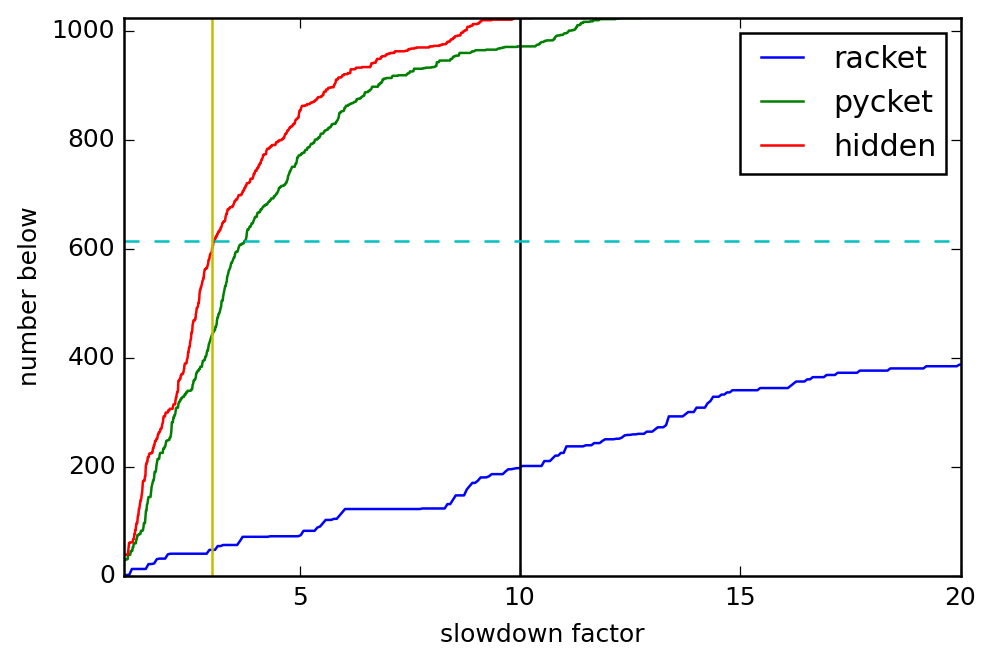

In [27]:
slowdown_cdf((racket_slowdown1, 'b', 'racket'),
             (pycket_slowdown1, 'g', 'pycket'),
             (hidden_slowdown1, 'r', 'hidden'))

## L = 2

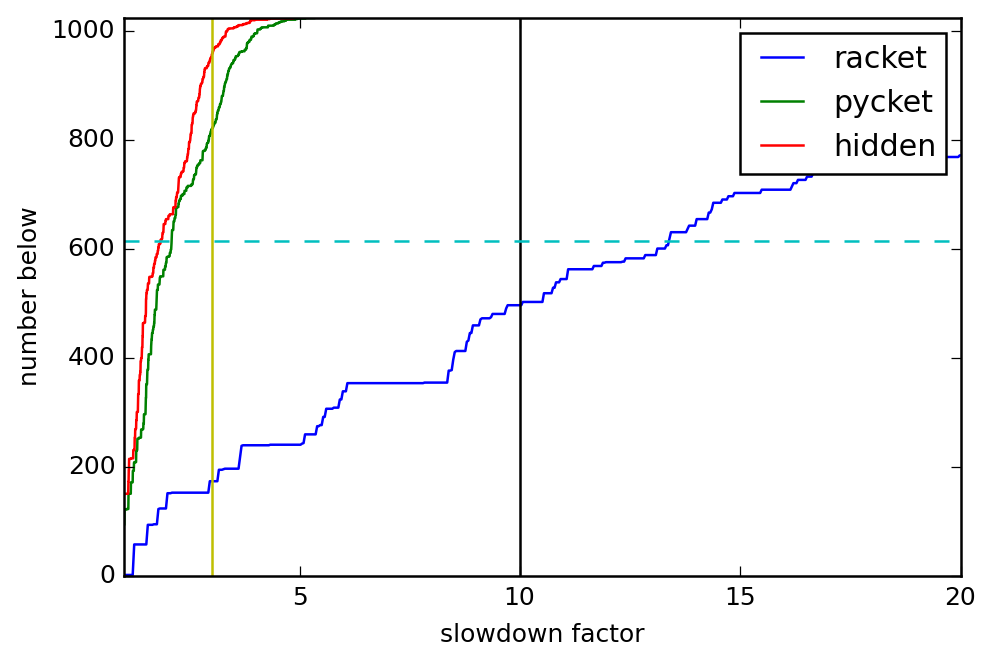

In [28]:
slowdown_cdf((racket_slowdown2, 'b', 'racket'),
             (pycket_slowdown2, 'g', 'pycket'),
             (hidden_slowdown2, 'r', 'hidden'))